In [1]:
import pandas as pd
import numpy as np
header = ['企业编码','排污口编码','污染物编码','记录时间','污染物浓度','污染物排放量']
pollution = pd.read_csv("all_data.csv", names=header, encoding='utf-8', low_memory=False)
pollution.dropna()
pollution.head()

,企业编码,排污口编码,污染物编码,记录时间,污染物浓度,污染物排放量
0,17280000089583,64000000000600100000,w00000,1/1/2020 00:00:00,66.25,870.0
1,17280000089583,64000000000600100000,w00000,2/1/2020 00:00:00,73.18,1758.0
2,17280000089583,64000000000600100000,w00000,3/1/2020 00:00:00,79.95,1918.0
3,17280000089583,64000000000600100000,w00000,4/1/2020 00:00:00,69.91,1678.0
4,17280000089583,64000000000600100000,w00000,5/1/2020 00:00:00,NaN,74.0


In [ ]:
# pollution = pollution.sort_values(by=["记录时间", "企业编码", "排污口编码"])
# pollution.set_index(["记录时间", "企业编码","排污口编码"])
pollution_shaped = pd.pivot_table(pollution,index =["记录时间", "企业编码","排污口编码"],values=["污染物浓度", "污染物排放量"],columns='污染物编码')
pollution_mean = pollution_shaped.count(axis=0).mean()
for key, count in pollution_shaped.count(axis=0).items():
    if count < pollution_mean:
        pollution_shaped.drop(key, axis=1, inplace=True)
pollution_vaild = pollution_shaped.dropna()
pollution_vaild

/Users/junpenglu/git/Illegal-pollution/env/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/junpenglu/git/Illegal-pollution/env/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


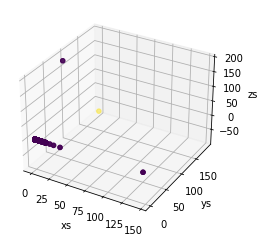

In [8]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA as PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 50
pd.options.display.max_columns = 20

name = pollution_vaild.index
out_class = pollution_vaild.keys()
data_2 = pollution_vaild

def pca(input_data,name):
    X_data1 = input_data#聚类数据，
    Sta=StandardScaler()###加标准化，不想要标准化可以注释掉这两句
    Sta.fit(X=X_data1)####标准化用均值跟方差算的，对有个别极值的点不敏感
    # MM=MinMaxScaler()#######最大最小归一化，现在是屏蔽的，想用这个可以取消屏蔽，这个和标准化只能选一个用
    # MM.fit(X=X_data1)#####最大最小归一化是用最大值和最小值算的，对极值比较敏感，这里可能不适用
    output=X_data1
    X_data1=Sta.transform(X_data1)
    pca = PCA(n_components=3)
    pca = pca.fit(X_data1)#降维
    X_dr = pca.transform(X_data1)#执行降维
    kmeans = KMeans(n_clusters=2,init='k-means++', n_init=10,  max_iter=300, tol=0.0001,
           verbose=0,  random_state=None,  copy_x=True,   algorithm='auto'
           )#使用Kmeans聚类，聚2类，初始化方式k-means++，随机初始质心10，最大迭代次数300，相关的扰动在两次迭代的聚类中心，
    kmeans.fit(X_data1)
    y_kmeans = kmeans.predict(X_data1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for c, m, zlow, zhigh in [('r', 'o', -500, -250), ('b', '^', -300, -50)]:
        xs =X_dr[:,0]
        ys = X_dr[:,1]
        zs = X_dr[:,2]
        ax.scatter(xs, ys, zs, c=y_kmeans, marker='o')
    ax.set_xlabel('xs')
    ax.set_ylabel('ys')
    ax.set_zlabel('zs')
    plt.show()
    name=np.reshape(name,(-1,1))
    y_kmeans=np.reshape(y_kmeans,(-1,1))
    out=np.concatenate((name,y_kmeans),axis=1)
    np.savetxt('result1.csv',out,fmt='%s')


pca(pollution_vaild,name)
# pca(data_2,name)



In [264]:
from collections import defaultdict
# 清洗数据，去除带空值的行
pollution = pollution.dropna()

full_poll = defaultdict(dict)
company_no = ""
poll_port_no = ""
poll_no = ""
for line in pollution.values:
    # if poll_no != line[2]:
    #     poll_no = line[2]
    #     if poll_port_no != line[1]:
    #         poll_port_no = line[1]
    #         if company_no != line[0]:
    #             company_no = line[0]
    try:
        full_poll[line[3]][line[0]][line[1]][line[2]] = list(line[4:])
    except KeyError:
        full_poll[line[3]][line[0]] = defaultdict(dict)
        full_poll[line[3]][line[0]][line[1]][line[2]] = list(line[4:])

for date in list(full_poll.keys()):
    drops = set()
    for company_key, poll in full_poll[date].items():
        for data in poll.values():
            if len(data.keys()) < 6:
                # print(f"pop {company_key}")
                drops.add(company_key)
    for drop in drops:
        full_poll[date].pop(drop)
    if not full_poll[date]:
        full_poll.pop(date)
